## 1)Import the required packages

In [13]:
#While importing, it is important that both problem_formulation1 and problem_formulation are loaded since we changed the objectives of model 
#when we run MORDM at the bottom

In [32]:
import numpy as np
import pandas as pd
import itertools
import time
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator, 
                           Scenario, Constraint, Policy,
                           ScalarOutcome,RealParameter,IntegerParameter,Constant)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import (perform_experiments, optimize,
                                                   BaseEvaluator)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol


from problem_formulation import get_model_for_problem_formulation
from problem_formulation1 import get_model_for_problem_formulation1

%matplotlib inline

ema_logging.log_to_stderr(ema_logging.INFO)

BaseEvaluator.reporting_frequency = 0.01

## 2) Performance of 9 policies selected out of MORO results

In [47]:
MORO_res= pd.read_csv("archive17500noEWS9best.csv")                                                #This csv file will have the 4 or 5 policies with highest score in robustness metric relating to death
MORO_res = MORO_res.drop(['Column1'],axis=1)                     #Most probably,this columns wont be present in the csv file you have.So you can comment this part if you have to
MORO_pol= MORO_res.iloc[:,0:21]                                                       #Selecting columns only with lever values

fin_levers = MORO_pol                                                                 #Final levers after applying political constraints
fin_levers = fin_levers.reset_index()
fin_levers = fin_levers.rename(index={0:'policy1',1:'policy2',2:'policy3',3:'policy4', #Just naming the policies
                                     4:'policy5',5:'policy6',6:'policy7',7:'policy8',8:'policy9' })
fin_levers = fin_levers.drop(['index'],axis=1)                                         #Drop this unnecessary columns
policies = []     
for i,lever in enumerate(fin_levers.index):                                            #Converting levers to dictionary   
    policy = fin_levers.loc[lever].to_dict()
    policy = Policy(fin_levers.index[i], **policy)
    policies.append(policy)

In [ ]:
#n_scenarios = 2000

#start = time.time()
#with MultiprocessingEvaluator(dike_model) as evaluator:
#    results = evaluator.perform_experiments(scenarios=n_scenarios, policies=policies)
#    end = time.time()
#print(round((end - start)/3600, 2), "Hours")
#save_results(results, "MORO4pol_lessdikeheightnorfrG.tar.gz")

In [54]:
#Load results
results = load_results('RUCHIK_0_new.tar.gz')
experiment,_ = results
results_df = pd.DataFrame.from_dict(_) 
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\MORDM_weak\RUCHIK_0_new.tar.gz


In [55]:
#In the highly disaggregated formulation, the damages and deaths are not aggregated over time,since we had two time steps
#we take average of values at each time step to get average annual damage and deaths each year
results_df['A.1_Expected Annual Damage'] = 0.5*(results_df['A.1_Expected Annual Damage 0'] + results_df['A.1_Expected Annual Damage 1'])
results_df['A.2_Expected Annual Damage'] = 0.5*(results_df['A.2_Expected Annual Damage 0'] + results_df['A.2_Expected Annual Damage 1'])
results_df['A.3_Expected Annual Damage'] = 0.5*(results_df['A.3_Expected Annual Damage 0'] + results_df['A.3_Expected Annual Damage 1'])
results_df['A.4_Expected Annual Damage'] = 0.5*(results_df['A.4_Expected Annual Damage 0'] + results_df['A.4_Expected Annual Damage 1'])
results_df['A.5_Expected Annual Damage'] = 0.5*(results_df['A.5_Expected Annual Damage 0'] + results_df['A.5_Expected Annual Damage 1'])
results_df['A.1_Expected Number of Deaths'] = 0.5*(results_df['A.1_Expected Number of Deaths 0'] + results_df['A.1_Expected Number of Deaths 1'])
results_df['A.2_Expected Number of Deaths'] = 0.5*(results_df['A.2_Expected Number of Deaths 0'] + results_df['A.2_Expected Number of Deaths 1'])
results_df['A.3_Expected Number of Deaths'] = 0.5*(results_df['A.3_Expected Number of Deaths 0'] + results_df['A.3_Expected Number of Deaths 1'])
results_df['A.4_Expected Number of Deaths'] = 0.5*(results_df['A.4_Expected Number of Deaths 0'] + results_df['A.4_Expected Number of Deaths 1'])
results_df['A.5_Expected Number of Deaths'] = 0.5*(results_df['A.5_Expected Number of Deaths 0'] + results_df['A.5_Expected Number of Deaths 1'])

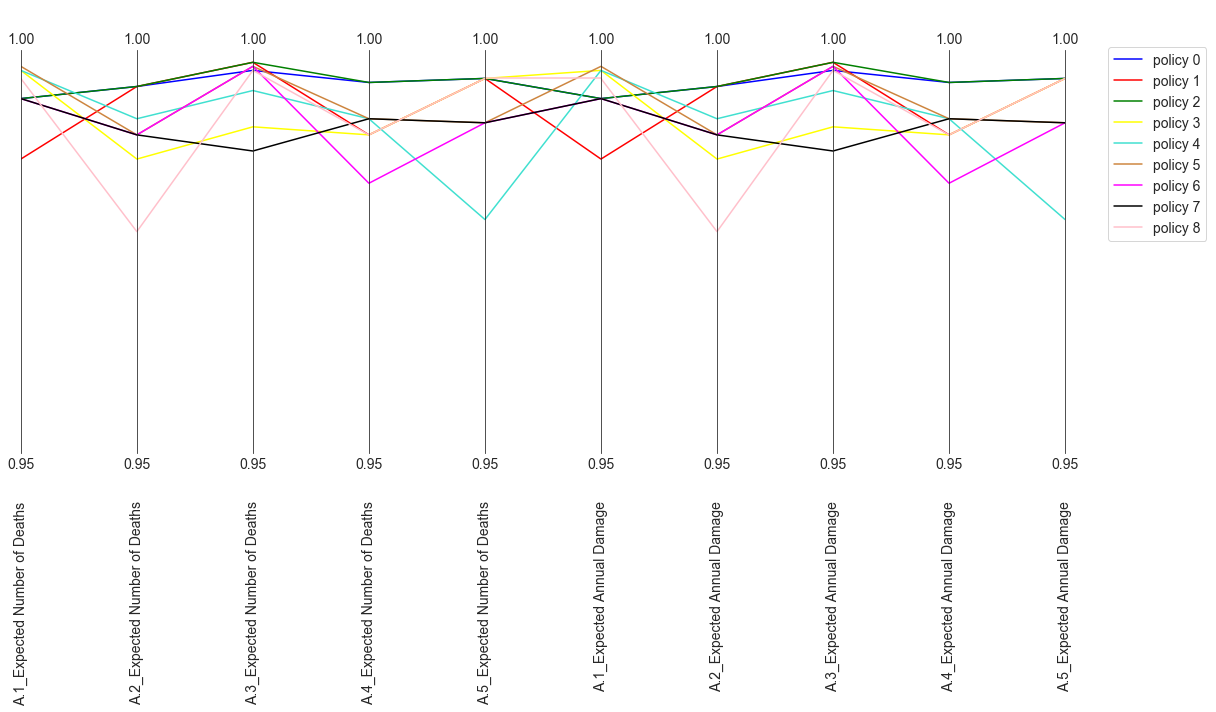

In [59]:
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']                 #A column to see which row corresponds to which policy in results   
objectives = ['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths',     #Objectives for which we want parallel coordinate plot
             'A.3_Expected Number of Deaths','A.4_Expected Number of Deaths',
             'A.5_Expected Number of Deaths','A.1_Expected Annual Damage',
             'A.2_Expected Annual Damage','A.3_Expected Annual Damage',
             'A.4_Expected Annual Damage','A.5_Expected Annual Damage']

for obj in objectives:
    robustness = []                                      #This list will contain robustness metric of specific objective for each policy
    for i in range(0, len(results_df['name'].unique())):                #looping through each policy
        df_pol = results_df[results_df['name']==results_df['name'].unique()[i]]
        if ('Deaths' in obj):                                            #if objective is related to death
            robustness_policy_outcome = len(df_pol[df_pol[obj]< 0.000002])/len(df_pol)     #find fraction which is below a threshold specified
            robustness.append(robustness_policy_outcome)                 #append it to list
        else:                                                            #if objective is related to damage
            robustness_policy_outcome = len(df_pol[df_pol[obj]<20000])/len(df_pol)    #find fraction which is below a specified threshold  
            robustness.append(robustness_policy_outcome)
    robustness_dict[obj] = robustness                                   #The element of dictionary is list with objective as key
robust_df = pd.DataFrame(data=robustness_dict)                          #convert it to dataframe
limits = pd.DataFrame([[0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95],[1,1,1,1,1,1,1,1,1,1]], columns=objectives)  #set limits
axes = parcoords.ParallelAxes(limits) 
colors = ['blue','red','green','yellow','turquoise','peru','magenta','black','pink']                                #change colors depending on number of policies you have
for i in range(0,len(robust_df)):
    outcomes = robust_df.iloc[i]
    axes.plot(outcomes.to_frame().T,label='policy {}'.format(i),color = colors[i])
axes.fig.set_size_inches(15,10)
axes.legend()
plt.show()

## Boxplot

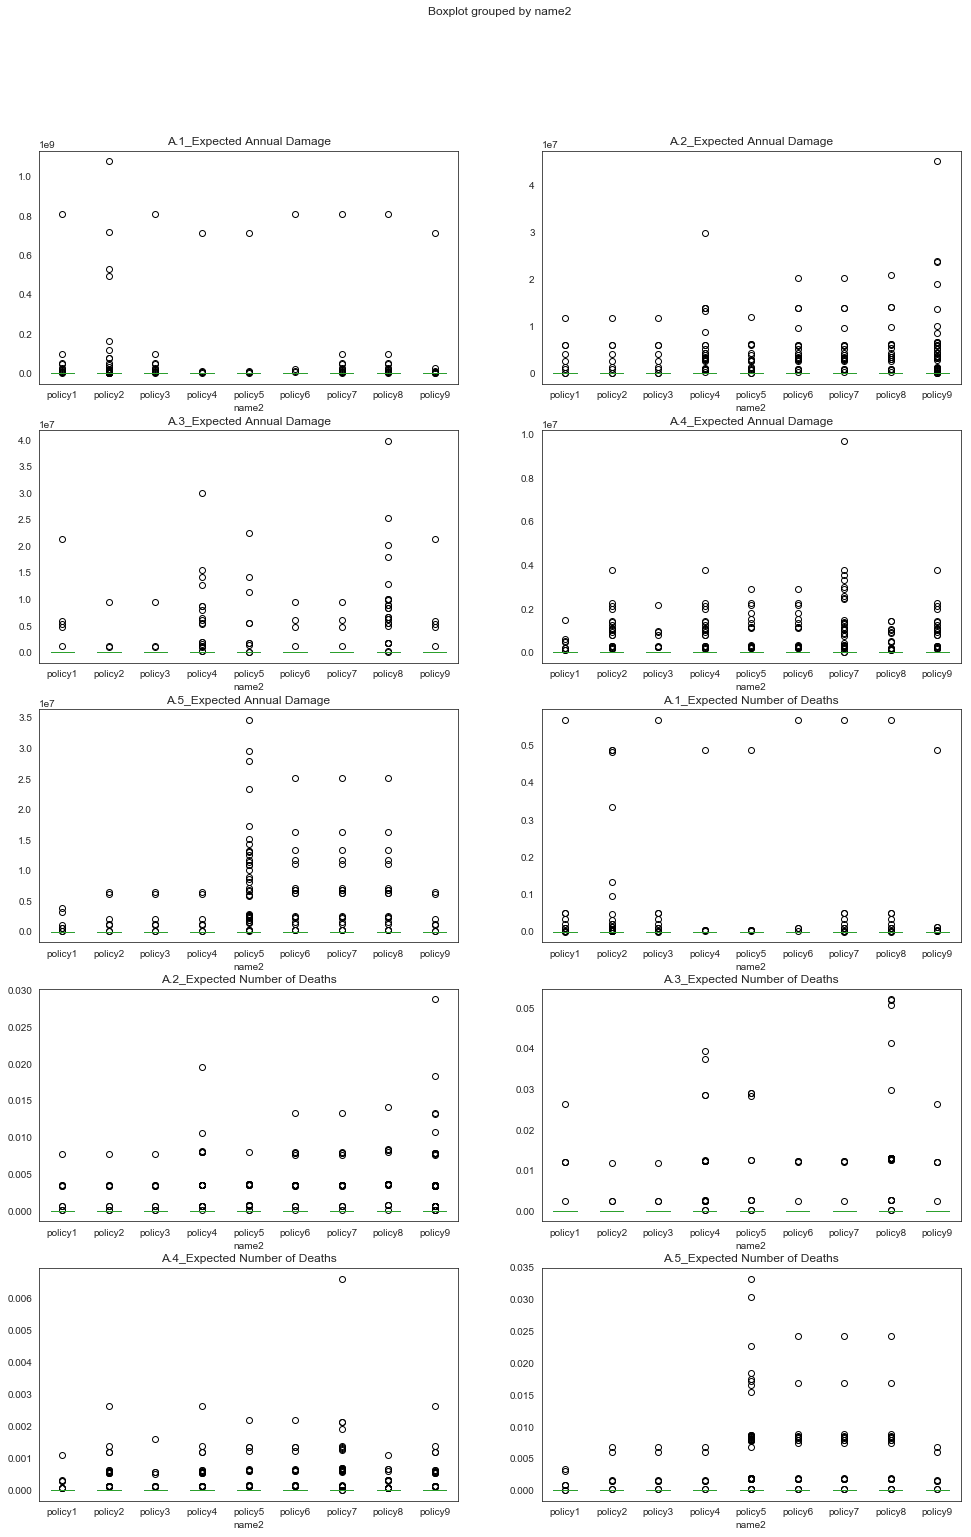

In [58]:
results_df['name2'] = results_df['name']                                           #Just replicating a column
results_df2 = results_df.iloc[:,35:50]                                             #Selecting time aggregated columns
col = 2                                                                            #plot the boxplots in a 2 column 5 row arrangement
row = 5
fig,ax = plt.subplots(row,col,figsize=(8*col,5*row))
location = list(itertools.product(range(row),range(col)))
fig.suptitle('Boxplots for each objective')
for i in range (0,len(results_df2.columns)-1):
    locat = location[i]
    results_df.boxplot(column=[results_df2.columns[i]],by='name2',ax = ax[locat],grid=False)

## 3) Performance of 9 Policies when all political constraints are applied

In this step in the 9 policies chosen from the results of MORO, the following political constraints will be applied:

- No room for the river in places rural places.
- Reduce dike heightening at A4 to 5 dm and at A5 to 3 dm.

In [14]:
dike_model,planning_steps = get_model_for_problem_formulation(5)

In [15]:
MORO_res= pd.read_csv("archive17500noEWS9bestonrobustness.csv")                                                #This csv file will have the 4 or 5 policies with highest score in robustness metric relating to death
MORO_res = MORO_res.drop(['aaa'],axis=1)                     #Most probably,this columns wont be present in the csv file you have.So you can comment this part if you have to
MORO_pol= MORO_res.iloc[:,0:21]                                                       #Selecting columns only with lever values
MORO_pol['A.4_DikeIncrease 0'] = 5                                                    #Increase dike height at 4 and 5 by 5 and 3 dm respectively
MORO_pol['A.5_DikeIncrease 0'] = 3
MORO_pol['0_RfR 0'] = 0                                                               #Farmers oppose RfR in areas 1 and 2 since they lose their
MORO_pol['0_RfR 1'] = 0                                                               #farm
MORO_pol['1_RfR 0'] = 0
MORO_pol['1_RfR 1'] = 0
MORO_pol['3_RfR 1'] = 0
fin_levers = MORO_pol                                                                 #Final levers after applying political constraints
fin_levers = fin_levers.reset_index()
fin_levers = fin_levers.rename(index={0:'policy1',1:'policy2',2:'policy3',3:'policy4', #Just naming the policies
                                     4:'policy5',5:'policy6',6:'policy7',7:'policy8',8:'policy9' })
fin_levers = fin_levers.drop(['index'],axis=1)                                         #Drop this unnecessary columns
policies = []     
for i,lever in enumerate(fin_levers.index):                                            #Converting levers to dictionary   
    policy = fin_levers.loc[lever].to_dict()
    policy = Policy(fin_levers.index[i], **policy)
    policies.append(policy)

In [3]:
# n_scenarios = 2000

# start = time.time()
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios, policies=policies)
#     end = time.time()
# print(round((end - start)/3600, 2), "Hours")
# save_results(results, "MORO4pol_lessdikeheightnorfrG.tar.gz")

In [4]:
#Load results
results = load_results('RUCHIK_1_new.tar.gz')
experiment,_ = results
results_df = pd.DataFrame.from_dict(_) 
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']

[MainProcess/INFO] results loaded succesfully from C:\Users\pvbia\OneDrive\Documentos\GitHub\MBDM-group-11\final assignment\MORDM_weak\RUCHIK_1_new.tar.gz


In [5]:
#In the highly disaggregated formulation, the damages and deaths are not aggregated over time,since we had two time steps
#we take average of values at each time step to get average annual damage and deaths each year
results_df['A.1_Expected Annual Damage'] = 0.5*(results_df['A.1_Expected Annual Damage 0'] + results_df['A.1_Expected Annual Damage 1'])
results_df['A.2_Expected Annual Damage'] = 0.5*(results_df['A.2_Expected Annual Damage 0'] + results_df['A.2_Expected Annual Damage 1'])
results_df['A.3_Expected Annual Damage'] = 0.5*(results_df['A.3_Expected Annual Damage 0'] + results_df['A.3_Expected Annual Damage 1'])
results_df['A.4_Expected Annual Damage'] = 0.5*(results_df['A.4_Expected Annual Damage 0'] + results_df['A.4_Expected Annual Damage 1'])
results_df['A.5_Expected Annual Damage'] = 0.5*(results_df['A.5_Expected Annual Damage 0'] + results_df['A.5_Expected Annual Damage 1'])
results_df['A.1_Expected Number of Deaths'] = 0.5*(results_df['A.1_Expected Number of Deaths 0'] + results_df['A.1_Expected Number of Deaths 1'])
results_df['A.2_Expected Number of Deaths'] = 0.5*(results_df['A.2_Expected Number of Deaths 0'] + results_df['A.2_Expected Number of Deaths 1'])
results_df['A.3_Expected Number of Deaths'] = 0.5*(results_df['A.3_Expected Number of Deaths 0'] + results_df['A.3_Expected Number of Deaths 1'])
results_df['A.4_Expected Number of Deaths'] = 0.5*(results_df['A.4_Expected Number of Deaths 0'] + results_df['A.4_Expected Number of Deaths 1'])
results_df['A.5_Expected Number of Deaths'] = 0.5*(results_df['A.5_Expected Number of Deaths 0'] + results_df['A.5_Expected Number of Deaths 1'])

### parallel axes plots

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


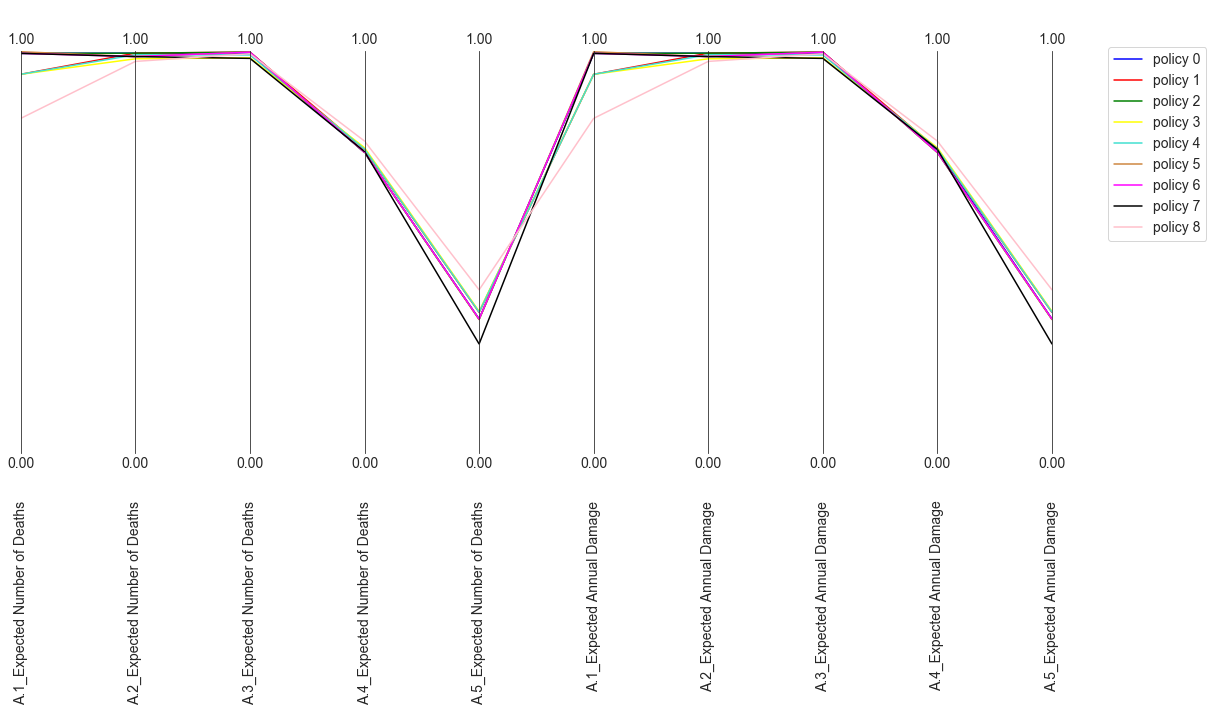

In [6]:
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']                 #A column to see which row corresponds to which policy in results   
objectives = ['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths',     #Objectives for which we want parallel coordinate plot
             'A.3_Expected Number of Deaths','A.4_Expected Number of Deaths',
             'A.5_Expected Number of Deaths','A.1_Expected Annual Damage',
             'A.2_Expected Annual Damage','A.3_Expected Annual Damage',
             'A.4_Expected Annual Damage','A.5_Expected Annual Damage']

for obj in objectives:
    robustness = []                                      #This list will contain robustness metric of specific objective for each policy
    for i in range(0, len(results_df['name'].unique())):                #looping through each policy
        df_pol = results_df[results_df['name']==results_df['name'].unique()[i]]
        if ('Deaths' in obj):                                            #if objective is related to death
            robustness_policy_outcome = len(df_pol[df_pol[obj]< 0.000002])/len(df_pol)     #find fraction which is below a threshold specified
            robustness.append(robustness_policy_outcome)                 #append it to list
        else:                                                            #if objective is related to damage
            robustness_policy_outcome = len(df_pol[df_pol[obj]<20000])/len(df_pol)    #find fraction which is below a specified threshold  
            robustness.append(robustness_policy_outcome)
    robustness_dict[obj] = robustness                                   #The element of dictionary is list with objective as key
robust_df = pd.DataFrame(data=robustness_dict)                          #convert it to dataframe
limits = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1]], columns=objectives)  #set limits
axes = parcoords.ParallelAxes(limits) 
colors = ['blue','red','green','yellow','turquoise','peru','magenta','black','pink']                                #change colors depending on number of policies you have
for i in range(0,len(robust_df)):
    outcomes = robust_df.iloc[i]
    axes.plot(outcomes.to_frame().T,label='policy {}'.format(i),color = colors[i])
axes.fig.set_size_inches(15,10)
axes.legend()
plt.show()

## Boxplot

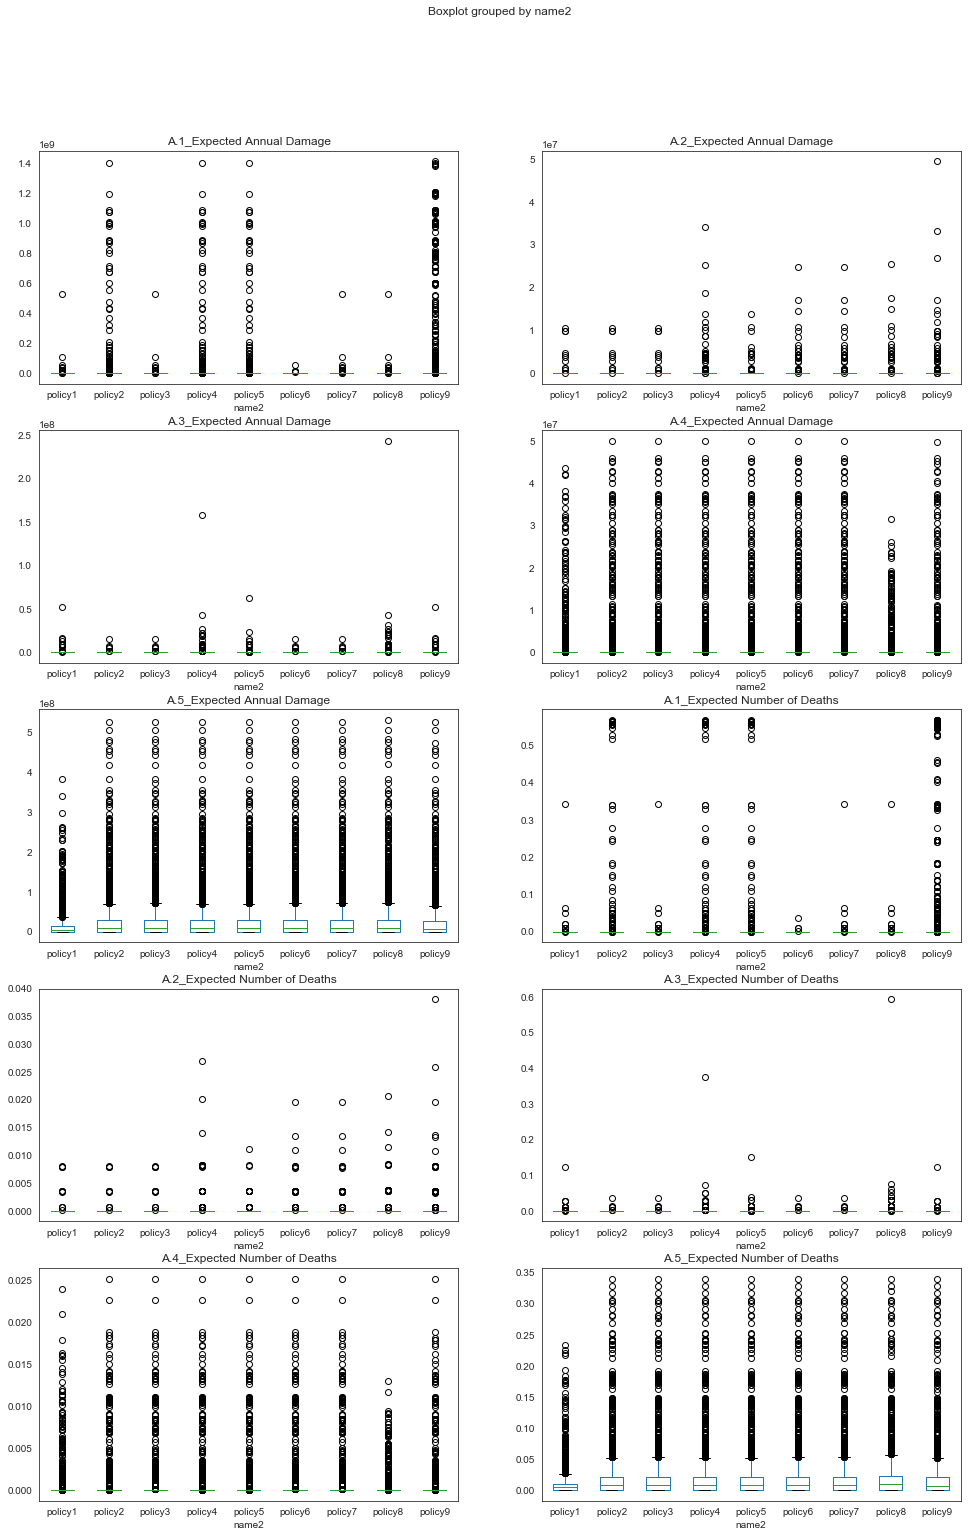

In [7]:
results_df['name2'] = results_df['name']                                           #Just replicating a column
results_df2 = results_df.iloc[:,35:50]                                             #Selecting time aggregated columns
col = 2                                                                            #plot the boxplots in a 2 column 5 row arrangement
row = 5
fig,ax = plt.subplots(row,col,figsize=(8*col,5*row))
location = list(itertools.product(range(row),range(col)))
fig.suptitle('Boxplots for each objective')
for i in range (0,len(results_df2.columns)-1):
    locat = location[i]
    results_df.boxplot(column=[results_df2.columns[i]],by='name2',ax = ax[locat],grid=False)

## 4) Performance of 9 policies with partial political constraints applied

In [ ]:
MORO_res= pd.read_csv("archive17500noEWS9bestonrobustness.csv")                                                #This csv file will have the 4 or 5 policies with highest score in robustness metric relating to death
MORO_res = MORO_res.drop(['aaa'],axis=1)                     #Most probably,this columns wont be present in the csv file you have.So you can comment this part if you have to
MORO_pol= MORO_res.iloc[:,0:21]                                                       #Selecting columns only with lever values
MORO_pol['A.4_DikeIncrease 0'] = 5                                                    #Increase dike height at 4 and 5 by 5 and 3 dm respectively
MORO_pol['A.5_DikeIncrease 0'] = 3
MORO_pol['0_RfR 0'] = 0                                                               #Farmers oppose RfR in areas 1 and 2 since they lose their
MORO_pol['0_RfR 1'] = 0                                                               #farm
MORO_pol['1_RfR 0'] = 0
MORO_pol['1_RfR 1'] = 0
MORO_pol['3_RfR 1'] = 0
fin_levers = MORO_pol                                                                 #Final levers after applying political constraints
fin_levers = fin_levers.reset_index()
fin_levers = fin_levers.rename(index={0:'policy1',1:'policy2',2:'policy3',3:'policy4', #Just naming the policies
                                     4:'policy5',5:'policy6',6:'policy7',7:'policy8',8:'policy9' })
fin_levers = fin_levers.drop(['index'],axis=1)                                         #Drop this unnecessary columns
policies = []     
for i,lever in enumerate(fin_levers.index):                                            #Converting levers to dictionary   
    policy = fin_levers.loc[lever].to_dict()
    policy = Policy(fin_levers.index[i], **policy)
    policies.append(policy)

In [ ]:
n_scenarios = 2000

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios, policies=policies)
    end = time.time()
print(round((end - start)/3600, 2), "Hours")
save_results(results, "MORO4pol_lessdikeheightnorfrG.tar.gz")

In [9]:
#Load results
results = load_results('RUCHIK_2_new.tar.gz')
experiment,_ = results
results_df = pd.DataFrame.from_dict(_) 
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']

[MainProcess/INFO] results loaded succesfully from C:\Users\pvbia\OneDrive\Documentos\GitHub\MBDM-group-11\final assignment\MORDM_weak\RUCHIK_2_new.tar.gz


In [10]:
#In the highly disaggregated formulation, the damages and deaths are not aggregated over time,since we had two time steps
#we take average of values at each time step to get average annual damage and deaths each year
results_df['A.1_Expected Annual Damage'] = 0.5*(results_df['A.1_Expected Annual Damage 0'] + results_df['A.1_Expected Annual Damage 1'])
results_df['A.2_Expected Annual Damage'] = 0.5*(results_df['A.2_Expected Annual Damage 0'] + results_df['A.2_Expected Annual Damage 1'])
results_df['A.3_Expected Annual Damage'] = 0.5*(results_df['A.3_Expected Annual Damage 0'] + results_df['A.3_Expected Annual Damage 1'])
results_df['A.4_Expected Annual Damage'] = 0.5*(results_df['A.4_Expected Annual Damage 0'] + results_df['A.4_Expected Annual Damage 1'])
results_df['A.5_Expected Annual Damage'] = 0.5*(results_df['A.5_Expected Annual Damage 0'] + results_df['A.5_Expected Annual Damage 1'])
results_df['A.1_Expected Number of Deaths'] = 0.5*(results_df['A.1_Expected Number of Deaths 0'] + results_df['A.1_Expected Number of Deaths 1'])
results_df['A.2_Expected Number of Deaths'] = 0.5*(results_df['A.2_Expected Number of Deaths 0'] + results_df['A.2_Expected Number of Deaths 1'])
results_df['A.3_Expected Number of Deaths'] = 0.5*(results_df['A.3_Expected Number of Deaths 0'] + results_df['A.3_Expected Number of Deaths 1'])
results_df['A.4_Expected Number of Deaths'] = 0.5*(results_df['A.4_Expected Number of Deaths 0'] + results_df['A.4_Expected Number of Deaths 1'])
results_df['A.5_Expected Number of Deaths'] = 0.5*(results_df['A.5_Expected Number of Deaths 0'] + results_df['A.5_Expected Number of Deaths 1'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


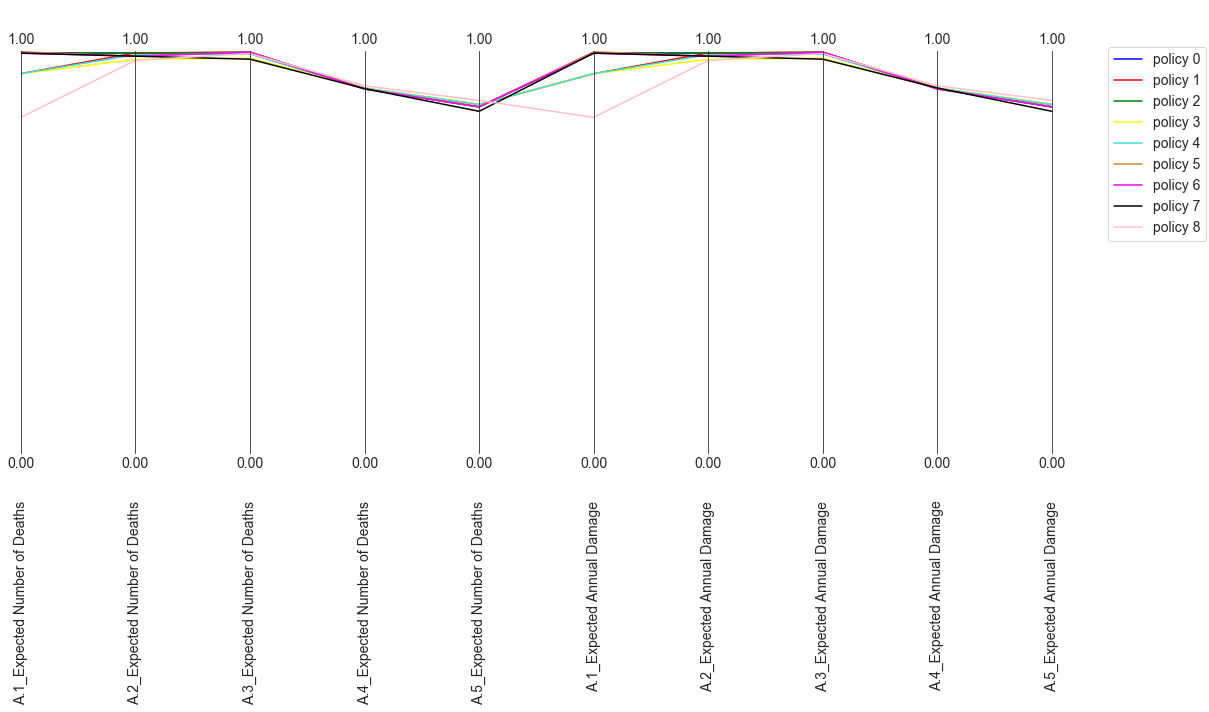

In [11]:
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']                 #A column to see which row corresponds to which policy in results   
objectives = ['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths',     #Objectives for which we want parallel coordinate plot
             'A.3_Expected Number of Deaths','A.4_Expected Number of Deaths',
             'A.5_Expected Number of Deaths','A.1_Expected Annual Damage',
             'A.2_Expected Annual Damage','A.3_Expected Annual Damage',
             'A.4_Expected Annual Damage','A.5_Expected Annual Damage']

for obj in objectives:
    robustness = []                                      #This list will contain robustness metric of specific objective for each policy
    for i in range(0, len(results_df['name'].unique())):                #looping through each policy
        df_pol = results_df[results_df['name']==results_df['name'].unique()[i]]
        if ('Deaths' in obj):                                            #if objective is related to death
            robustness_policy_outcome = len(df_pol[df_pol[obj]< 0.000002])/len(df_pol)     #find fraction which is below a threshold specified
            robustness.append(robustness_policy_outcome)                 #append it to list
        else:                                                            #if objective is related to damage
            robustness_policy_outcome = len(df_pol[df_pol[obj]<20000])/len(df_pol)    #find fraction which is below a specified threshold  
            robustness.append(robustness_policy_outcome)
    robustness_dict[obj] = robustness                                   #The element of dictionary is list with objective as key
robust_df = pd.DataFrame(data=robustness_dict)                          #convert it to dataframe
limits = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1]], columns=objectives)  #set limits
axes = parcoords.ParallelAxes(limits) 
colors = ['blue','red','green','yellow','turquoise','peru','magenta','black','pink']                                #change colors depending on number of policies you have
for i in range(0,len(robust_df)):
    outcomes = robust_df.iloc[i]
    axes.plot(outcomes.to_frame().T,label='policy {}'.format(i),color = colors[i])
axes.fig.set_size_inches(15,10)
axes.legend()
plt.show()

### boxplots

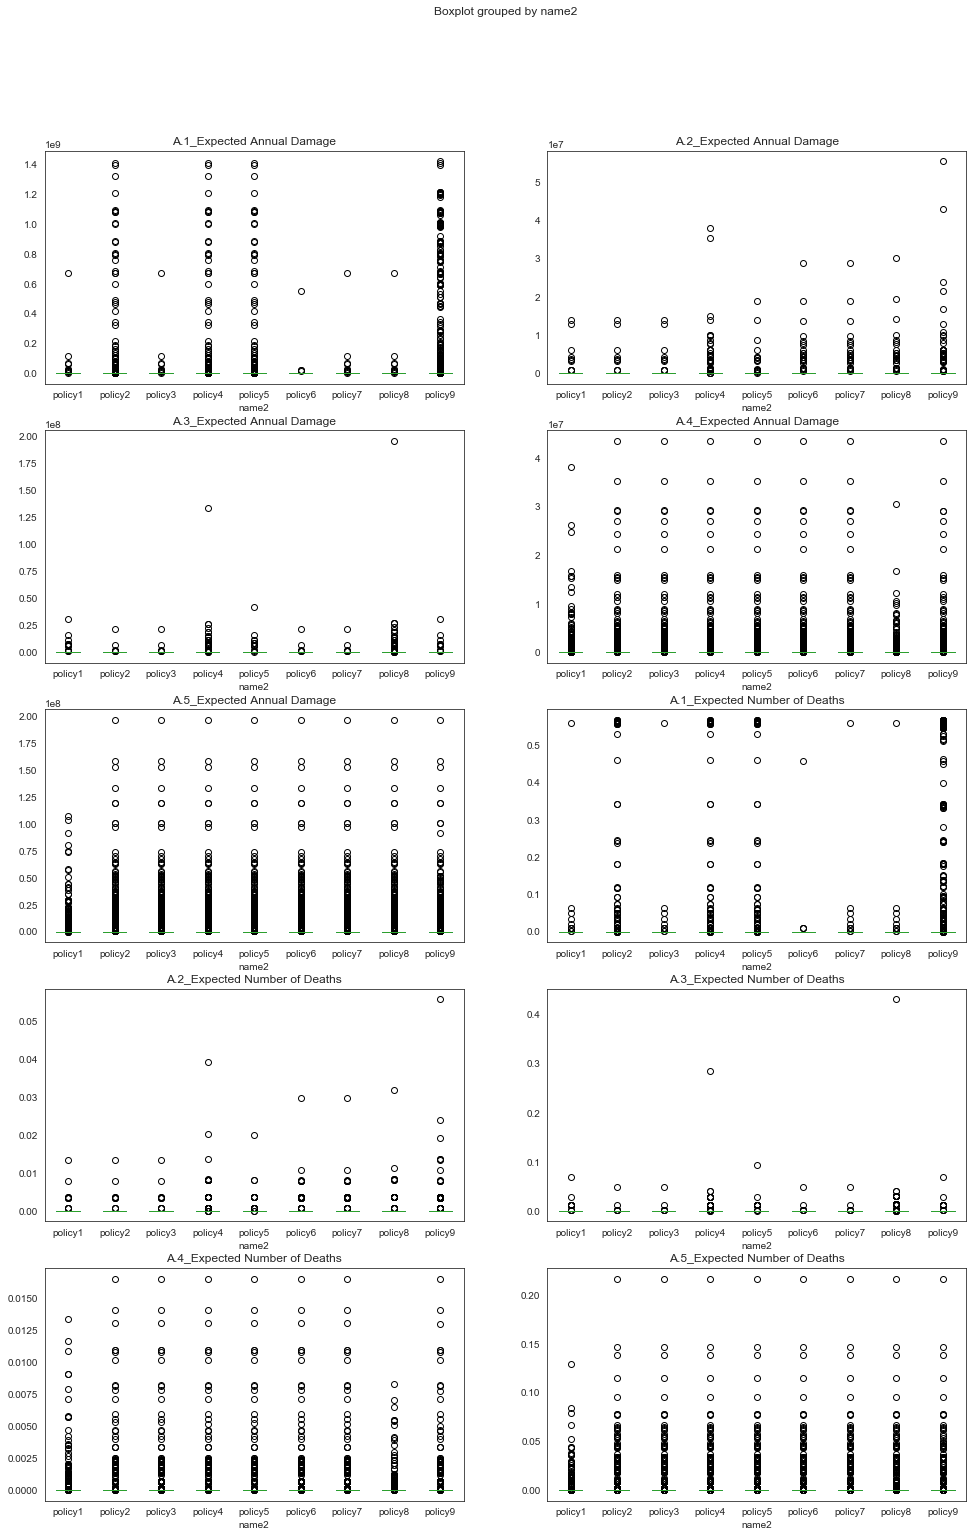

In [12]:
results_df['name2'] = results_df['name']                                           #Just replicating a column
results_df2 = results_df.iloc[:,35:50]                                             #Selecting time aggregated columns
col = 2                                                                            #plot the boxplots in a 2 column 5 row arrangement
row = 5
fig,ax = plt.subplots(row,col,figsize=(8*col,5*row))
location = list(itertools.product(range(row),range(col)))
fig.suptitle('Boxplots for each objective')
for i in range (0,len(results_df2.columns)-1):
    locat = location[i]
    results_df.boxplot(column=[results_df2.columns[i]],by='name2',ax = ax[locat],grid=False)

### pairplots

In [25]:
selected_policy = 'policy3'
experiment_pol = experiment[experiment['policy']== selected_policy]
experiment_pol = experiment_pol.reset_index()
results_pol = results_df2[results_df2['name2']== selected_policy]
results_pol = results_pol.reset_index()

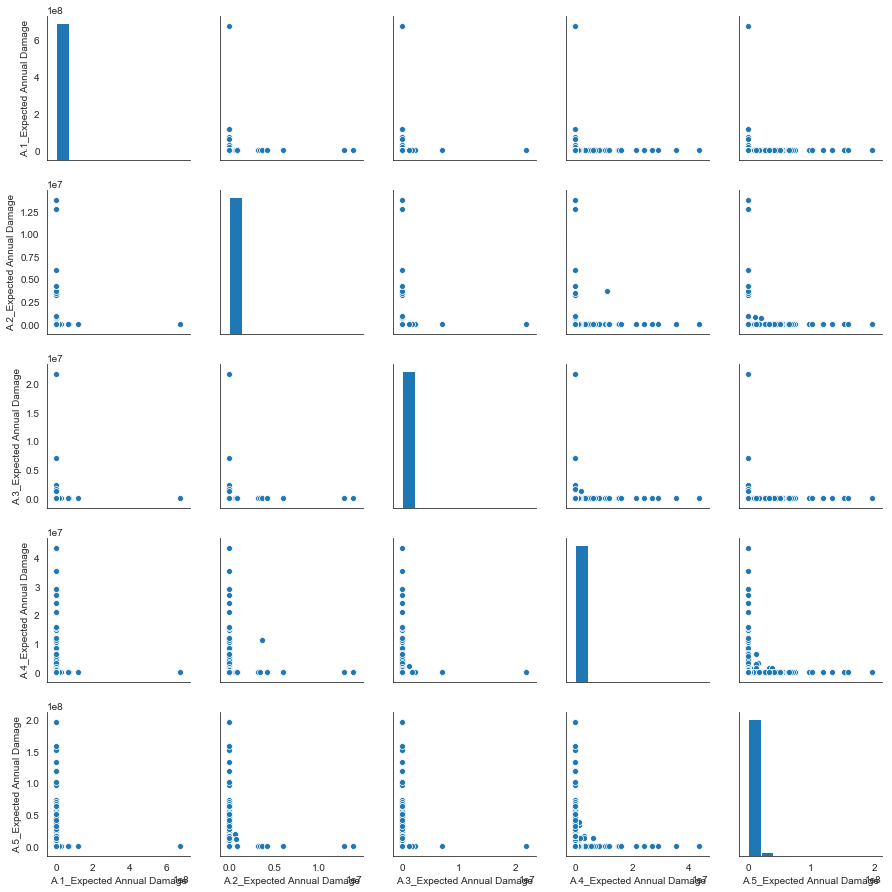

In [16]:
#Pairplot for damage at each location
#policy_selected = 
#results_df2  = results_df2[results_df2['name2']== policy_selected]
damage = results_pol[['A.1_Expected Annual Damage','A.2_Expected Annual Damage','A.3_Expected Annual Damage',
                     'A.4_Expected Annual Damage','A.5_Expected Annual Damage','name2']]
sns.pairplot(damage)

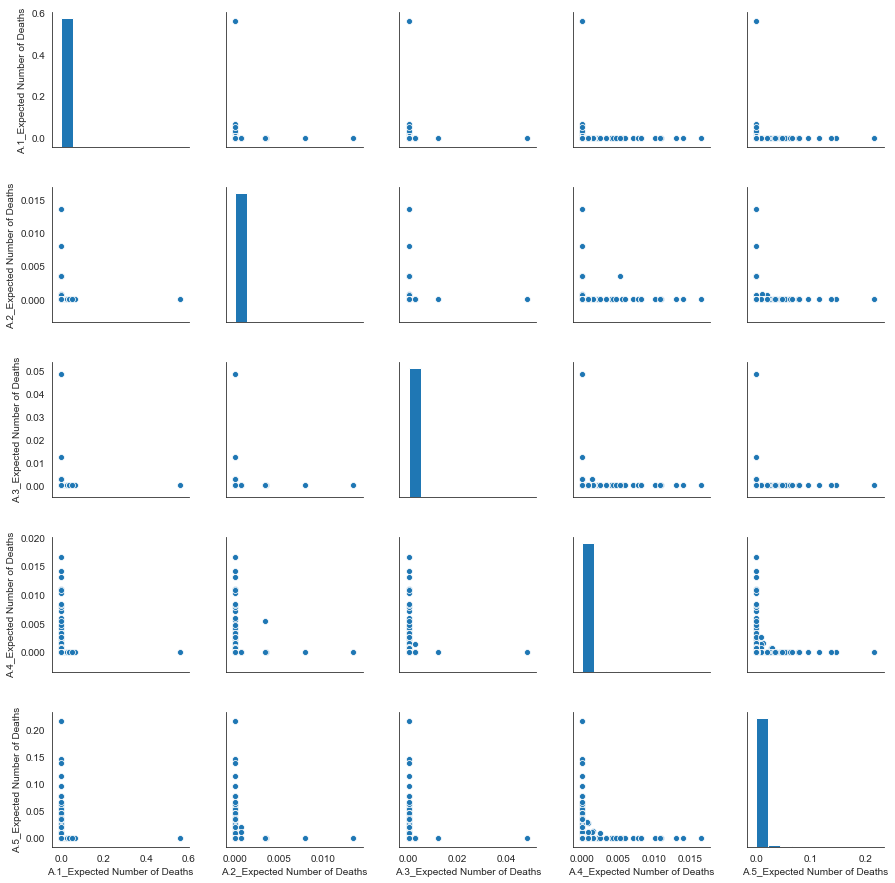

In [17]:
#Pairplot for death at each location
#policy_selected = 
#results_df2  = results_df2[results_df2['name2']== policy_selected]
deaths = results_pol[['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths','A.3_Expected Number of Deaths',
                      'A.4_Expected Number of Deaths','A.5_Expected Number of Deaths','name2']]
sns.pairplot(deaths)

### Subspace partitioning and Scenario discovery


In [39]:
#Define the function for success of policy under a scenario and apply it to the results.The scripts for
#performing PRIM and dimensional stacking on all policies is below.A policy is successful under a scenario
#if 7 out of its 10 objectives are below threshold
def success(df):
    for i in range (0,len(df)):
        if (df.loc[i,'A.1_Expected Number of Deaths']>0):
            a1 = 1
        else:
            a1 = 0
        if (df.loc[i,'A.2_Expected Number of Deaths']>0):
            a2 = 1
        else:
            a2 = 0
        if (df.loc[i,'A.3_Expected Number of Deaths']>0):
            a3 = 1
        else:
            a3 = 0
        if (df.loc[i,'A.4_Expected Number of Deaths']>20000):
            a4 = 1
        else:
            a4 = 0
        if (df.loc[i,'A.5_Expected Number of Deaths']>20000):
            a5 = 1
        else:
            a5 = 0
        if (df.loc[i,'A.1_Expected Annual Damage']>0):
            a6 = 1
        else:
            a6 = 0
        if (df.loc[i,'A.2_Expected Annual Damage']>0):
            a7 = 1
        else:
            a7 = 0
        if (df.loc[i,'A.3_Expected Annual Damage']>0):
            a8 = 1
        else:
            a8 = 0
        if (df.loc[i,'A.4_Expected Annual Damage']>0):
            a9 = 1
        else:
            a9 = 0
        if (df.loc[i,'A.5_Expected Annual Damage']>0):
            a10 = 1
        else:
            a10 = 0

        if ((a1+a2+a3+a4+a5+a6+a7+a8+a9+a10)>1):
            df.loc[i,'success']=1
        else:
            df.loc[i,'success']=0


In [40]:
policy_selected = 'policy6'
results_policy_selected = results_df[results_df['name']== policy_selected] 
results_policy_selected = results_policy_selected.reset_index()
success(results_policy_selected)                     #Apply the success fail criteria on policies
experiment_pol['success'] = results_policy_selected['success']      
diff_policies = {}                                        
for i in range (0,len(experiment_pol['policy'].unique())):                  #Divide each policy outcomes in dictionary keys
    df = experiment_pol[experiment_pol['policy']== experiment_pol['policy'].unique()[i]]
    string = 'policy' + str(i)
    diff_policies[policy_selected] = df

In [37]:
diff_policies['policy6'].columns

Index(['index', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate',
       'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax',
       'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail',
       'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0',
       'discount rate 1', '0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1',
       '2_RfR 0', '2_RfR 1', '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0',
       'A.3_DikeIncrease 1', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'scenario', 'policy',
       'model', 'success'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
[MainProcess/INFO] 2000 points remaining, containing 484 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.097, coverage: 0.40082644628099173, density: 1.0 restricted_dimensions: 2


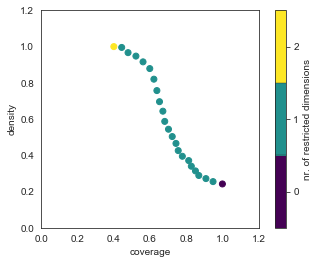

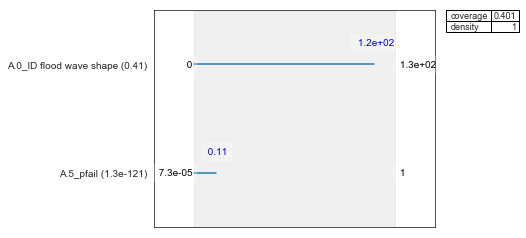

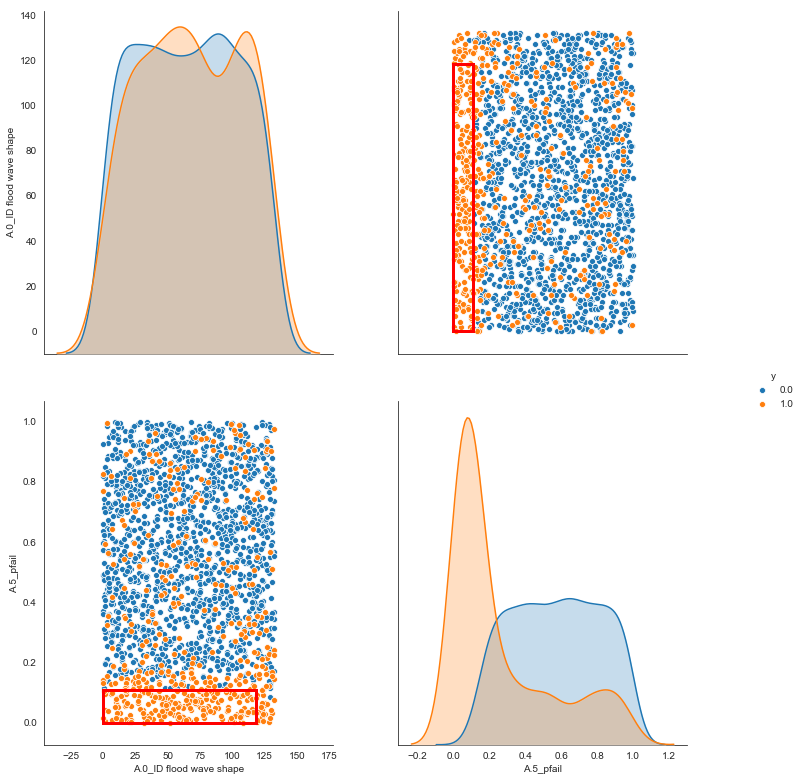

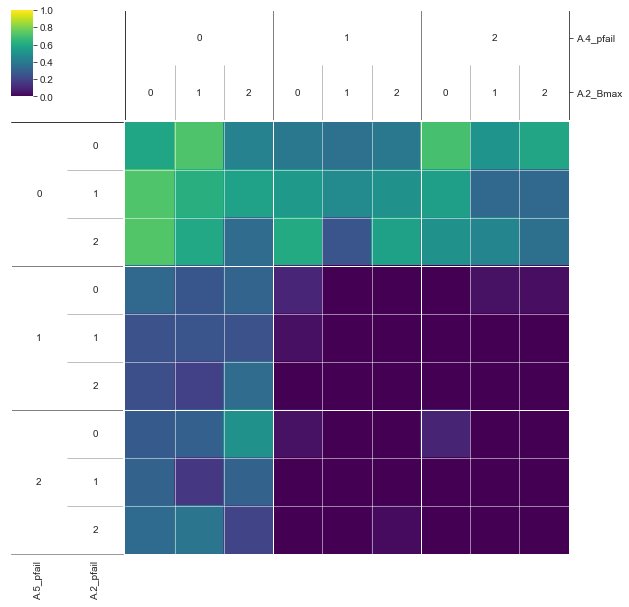

In [41]:
#Apply PRIM and Dimensional stacking to policies
def prim_analysis(dict_pol):
    for key in dict_pol:
        df_prim = dict_pol[key]
        x = df_prim.ix[:,1:19]
        y = df_prim['success']
        y = y.values
        prim_alg = prim.Prim(x, y, threshold=0.1, peel_alpha=0.1)
        box1 = prim_alg.find_box()
        box1.show_tradeoff()
        plt.show()
        box1.inspect(style='graph')
        plt.show()
        box1.show_pairs_scatter()
        fig = plt.gcf()
        fig.set_size_inches(12,12)
        plt.show()
        dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
        plt.show()
prim_analysis(diff_policies)

### Change model configuration

In [13]:
#Make sure you are loading the updated file of 'problem_formulation'
dike_model,planning_steps = get_model_for_problem_formulation1(0)
#Change dike model levers since MORO gave us optimal policy and we applied political constraints to it,some levers are fixed while
#we further optimize other levers.Change it accordingly
dike_model.levers = [IntegerParameter('0_RfR 0',0,1),IntegerParameter('0_RfR 1',0,1),
                     IntegerParameter('1_RfR 0',0,1),IntegerParameter('1_RfR 1',0,1),
                     IntegerParameter('3_RfR 0',0,1),IntegerParameter('3_RfR 1',0,1),
                     IntegerParameter('4_RfR 0',0,1),IntegerParameter('4_RfR 1',0,1),
                     IntegerParameter('A.1_DikeIncrease 1',0,10),IntegerParameter('A.2_DikeIncrease 1',0,10),
                     IntegerParameter('A.3_DikeIncrease 1',0,10),IntegerParameter('A.5_DikeIncrease 1',0,3)]
#This constants are levers whose value is obtained after MORO and political constraints
dike_model.constants = [Constant('EWS_DaysToThreat',0), Constant('A.1_DikeIncrease 0',10),Constant('A.2_DikeIncrease 0',9),
                        Constant('A.3_DikeIncrease 0',10),Constant('A.4_DikeIncrease 0',5), Constant('A.4_DikeIncrease 1',3), 
                        Constant('A.5_DikeIncrease 0',3)]
#Outcomes we want to give to MORDM
dike_model.outcomes = [ScalarOutcome('A.4_Expected Annual Damage 0',kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Annual Damage 1',kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Number of Deaths 0',kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Number of Deaths 1',kind=ScalarOutcome.MINIMIZE)]


### Do a vulnerability analysis on the selected best policy using SOBOL

In [ ]:
#in my case policy 3 is the best polciy. Since its index is 2, we selct policies[2]
policy_to_run = policies[2]
n_scenarios=1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments,outcomes = evaluator.perform_experiments(policies=policies[2],scenarios=n_scenarios,
                                                         uncertainty_sampling ='sobol')
results_df = pd.DataFrame.from_dict(outcomes) 
final_df = pd.concat([experiments,results_df],axis=1,sort=False)
final_df.to_csv('results_sobol_uncertainties.csv',index=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 380 scenarios * 1 policies * 1 model(s) = 380 experiments
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 76 cases completed
[MainProcess/INFO] 114 cases completed


### Selecting best policy from PRIM and do further analysis for pathways

In [11]:
# Select the name of best policy and input it below. In the test case it was 'Policy3'
results_pol3 = results_df2[results_df2['name2']== 'policy3']
results_pol3['tot_dam'] = results_pol3['A.4_Expected Annual Damage']+results_pol3['A.5_Expected Annual Damage']
results_pol3['tot_death'] = results_pol3['A.4_Expected Number of Deaths']+results_pol3['A.5_Expected Number of Deaths']
results_pol3_dam = results_pol3[['A.4_Expected Annual Damage','A.5_Expected Annual Damage','A.4_Expected Number of Deaths','A.5_Expected Number of Deaths',
                                 'tot_dam','tot_death']]
experiment_pol3 = experiment[experiment['policy']=='policy3']
pol3_df = pd.concat([experiment_pol3,results_pol3_dam],axis=1)
pol3_df = pol3_df.drop(['scenario','model','success'],axis=1)      #Drop the unnecessary column


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
#Sort the scenarios for worst case of each objective and create separate dataframes for each sorted objective
pol3_df_a4_dam = pol3_df.sort_values(by=['A.4_Expected Annual Damage'],ascending=False)
pol3_df_a4_dam = pol3_df_a4_dam.reset_index()
pol3_df_a5_dam = pol3_df.sort_values(by=['A.5_Expected Annual Damage'],ascending=False)
pol3_df_a5_dam = pol3_df_a5_dam.reset_index()
pol3_df_tot_dam = pol3_df.sort_values(by=['tot_dam'],ascending=False)
pol3_df_tot_dam = pol3_df_tot_dam.reset_index()
pol3_df_a4_dea = pol3_df.sort_values(by=['A.4_Expected Number of Deaths'],ascending=False)
pol3_df_a4_dea = pol3_df_a4_dea.reset_index()
pol3_df_a5_dea = pol3_df.sort_values(by=['A.5_Expected Number of Deaths'],ascending=False)
pol3_df_a5_dea = pol3_df_a5_dea.reset_index()
pol3_df_tot_dea = pol3_df.sort_values(by=['tot_death'],ascending=False)
pol3_df_tot_dea = pol3_df_tot_dea.reset_index()


In [13]:
#There will be 6 scenarios for 6 objective, new we create a data frame of length 6 for this 6 scenarios
scenario1=pol3_df_a4_dam.iloc[0]
scenario2=pol3_df_a5_dam.iloc[0]
scenario3 = pol3_df_tot_dam.iloc[0]
scenario4=pol3_df_a4_dea.iloc[0]
scenario5=pol3_df_a5_dea.iloc[0]
scenario6 = pol3_df_tot_dea.iloc[0]
scenarios = pd.concat([scenario1,scenario2,scenario3,scenario4,scenario5,scenario6],axis=1)
scenarios_tr=scenarios.T
scenarios_unc = scenarios_tr.iloc[:,1:19] 
#Convert the scenarios to dictionary. You need to visually inspect the dataframe scenarios_unc to select worst scenario at locations 4 and 5.
#in my case they were the 4th and 5th rows, hence 3rd and 4th indices
uncertainty1 = scenarios_unc.iloc[3].to_dict()
uncertainty_loc4= Scenario('uncertainty1', **uncertainty1)
uncertainty2 = scenarios_unc.iloc[4].to_dict()
uncertainty_loc5= Scenario('uncertainty2', **uncertainty2)


### Run MORDM on 2 selected worst case scenarios

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/500 nfe
[MainProcess/INFO] generation 1: 100/500 nfe
[MainProcess/INFO] generation 2: 198/500 nfe
[MainProcess/INFO] generation 3: 298/500 nfe
[MainProcess/INFO] generation 4: 397/500 nfe
[MainProcess/INFO] generation 5: 497/500 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\pvbia\OneDrive\Documentos\GitHub\MBDM-group-11\final assignment\MORDM_weak\scenario_loc4 MORDMruns_worst case scenario.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\pvbia\OneDrive\Documentos\GitHub\MBDM-group-11\final assignment\MORDM_weak\scenario_loc4 MORDMruns_worst case scenario.tar.gz


Text(0.5, 0, 'number of function evaluations')

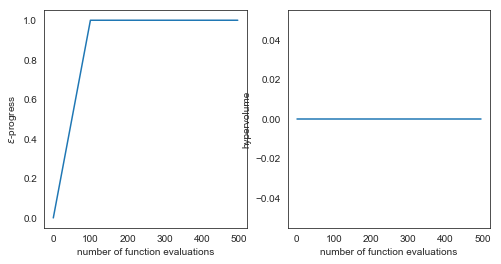

In [20]:
nfe_MORDM = 500

epsilon = [100000, 100000,0.001, 0.001]                     #I change this values but this is the solution we get even after changing 
                                                            # value many times

convergence_metrics = [HyperVolume(minimum=[0, 0, 0, 0], 
                                   maximum=[1,1,1,1]),
                       EpsilonProgress()]
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=nfe_MORDM, 
                                 searchover='levers',
                                 epsilons=epsilon,
                                 convergence=convergence_metrics,
                                 reference=uncertainty_loc4,logging_freq=1,convergence_freq=10)

save_results(results, 'scenario_loc4 MORDMruns_worst case scenario.tar.gz')
results = load_results('scenario_loc4 MORDMruns_worst case scenario.tar.gz')

outcomes, convergence = results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

In [21]:
convergence

{'hypervolume': array([0., 0., 0., 0., 0., 0.]),
 'epsilon_progress': array([0, 1, 1, 1, 1, 1], dtype=int64),
 'nfe': array([  0, 100, 198, 298, 397, 497], dtype=int64)}